In [35]:
# Load modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter

In [2]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("SEEROutput.csv",low_memory=False)
# Look at data header
# display(salivary_df.head())
display(salivary_df.info())
display(salivary_df.columns)

small_df = salivary_df.sample(1000)
small_df.to_csv('output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28030 entries, 0 to 28029
Data columns (total 64 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   Patient ID                                                 28030 non-null  int64 
 1   Age recode with <1 year olds                               28030 non-null  object
 2   Sex                                                        28030 non-null  object
 3   Year of diagnosis                                          28030 non-null  int64 
 4   PRCDA 2020                                                 28030 non-null  object
 5   Race recode (W, B, AI, API)                                28030 non-null  object
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    28030 non-null  object
 7   Site recode ICD-O-3/WHO 2008                               28030 non-null  object
 8   Behavior code IC

None

Index(['Patient ID', 'Age recode with <1 year olds', 'Sex',
       'Year of diagnosis', 'PRCDA 2020', 'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3',
       'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
       'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
       'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
       'ICD-O-3 Hist/behav, malignant', 'Histology recode - broad groupings',
       'Site recode ICD-O-3/WHO 2008 (for SIRs)',
       'Combined Summary Stage (2004+)', 'Summary stage 2000 (1998-2017)',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'SEER historic stage A (1973-2015)', 'RX Summ--Surg Prim Site (1998+)',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
       'Reason no can

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we may need to address missing values individually. They may be logged as, for example, 'XX' or '99'. As such, we will always view unique values in each column before evaluations


# Treatment Modalities Evaluation

In [48]:
colsOfInterest_Tx = ['RX Summ--Scope Reg LN Sur (2003+)',
                  'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
                  'Reason no cancer-directed surgery', 'Radiation recode',
                  'Chemotherapy recode (yes, no/unk)',
                  'RX Summ--Systemic/Sur Seq (2007+)']
for col in colsOfInterest_Tx:
    print(salivary_df[col].value_counts())

RX Summ--Scope Reg LN Sur (2003+)
4 or more regional lymph nodes removed                        8328
1 to 3 regional lymph nodes removed                           3993
Blank(s)                                                      3073
Unknown or not applicable                                     1689
Number of regional lymph nodes removed unknown                 408
Biopsy or aspiration of regional lymph node, NOS               367
Sentinel node biopsy and lym nd removed same/unstated time      37
Sentinel lymph node biopsy                                      31
Sentinel node biopsy and lym nd removed different times         17
Name: count, dtype: int64
RX Summ--Surg Oth Reg/Dis (2003+)
None; diagnosed at autopsy                                      23950
Blank(s)                                                         3073
Non-primary surgical procedure to other regional sites            337
Unknown; death certificate only                                   328
Non-primary surgical pr

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. It is frequent with database data to contain values other than explicit nan's. They may be logged as, for example, 'XX' or '99'. For each relevant column, we will need to view unique values and address missing values individually as needed.


# Age with 90+ and Other Categorical Adjustments 

In [4]:
# Select relevant columns for demographic analysis
age_colname = 'Age recode with single ages and 90+'
age_bin_colname = 'Age_Binned'
race_colname = 'Race recode (W, B, AI, API)'
sex_colname = 'Sex'
ses_colname = 'Median household income inflation adj to 2022'

demographic_columns = [age_colname,race_colname,sex_colname, ses_colname]

# Remove 'years'
salivary_df[age_colname] = salivary_df[age_colname].str.replace(' years','') 

# Organize age column as a categorical with numerical order
numerical_years = salivary_df[age_colname].str.extract(r'(\d+)').astype(float)
# print(numerical_years[0].unique())
# Input numerical age data into the dataframe
salivary_df['Numerical_Age'] = numerical_years


# Define 5-year bins from 0 to 90+, using float to allow for infinity in the final bin
bins = np.concatenate([np.arange(0, 95, 5), [np.inf]])  # Include infinity in the last bin

# Create labels for the bins, including '90+' for the last bin
labels = [f'{i}-{i+4}' for i in range(0, 90, 5)] + ['90+']

# Apply pd.cut to create the binned age categories
salivary_df[age_bin_colname] = pd.cut(salivary_df['Numerical_Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Check the unique values of the new binned age column
# print(salivary_df[age_bin_colname].unique())

In [5]:
# Create a mapping for values with leading zeros and handle special cases:
# - Convert '00' and '<1' to '≤1'
# - Remove leading zeros for values like '02', '03', etc.
# - Leave '90' as it is

sorted_ages = salivary_df[age_colname].unique()
age_mapping = {
    age: '≤1' if age == '00' or age == '<1' else (str(int(age)) if age.isdigit() and int(age) < 10 else age)
    for age in sorted_ages
}

# Replace values in the age column using the mapping
salivary_df[age_colname] = salivary_df[age_colname].replace(age_mapping)

# Get the sorted unique ages after the mapping has been applied
# Ensure '≤1' comes first by assigning key paramter = -1
# Otherwise: get rid of "+" at the end of 90
sorted_ages = sorted(
    salivary_df[age_colname].unique(),
    key=lambda x: (-1 if '≤1' in x else float(x.replace('+', '').replace('≤', '').replace('<', ''))) if x != '90+' else 90
)

# Convert the 'age_colname' column to categorical with sorted order
salivary_df[age_colname] = pd.Categorical(salivary_df[age_colname], categories=sorted_ages, ordered=True)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df[sex_colname] = pd.Categorical(
    salivary_df[sex_colname], categories=sex_order, ordered=True
)

# Race order
race_order = sorted(salivary_df[race_colname].unique())

# Convert race column to reflect new world order
salivary_df[race_colname] = pd.Categorical(
    salivary_df[race_colname], categories=race_order, ordered=True
)

# display(salivary_df[age_colname].unique)



In [6]:
# SES
# sorted_ses_mapping = {
#     salivary_df[ses_colname].unique()
# }
# Define the order of categories, excluding the "Unknown/missing/no match/Not 1990-2022"
socioeconomic_order = [
    "<$40,000", "$40,000 - $44,999", "$45,000 - $49,999", "$50,000 - $54,999",
    "$55,000 - $59,999", "$60,000 - $64,999", "$65,000 - $69,999", "$70,000 - $74,999",
    "$75,000 - $79,999", "$80,000 - $84,999", "$85,000 - $89,999", "$90,000 - $94,999",
    "$95,000 - $99,999", "$100,000 - $109,999", "$110,000 - $119,999", "$120,000+"
]

# Change to categorical
salivary_df[ses_colname] = pd.Categorical(
    salivary_df[ses_colname],
    categories=socioeconomic_order,
    ordered=True
)
display(salivary_df[ses_colname].unique())

# Categorize histological types - based on Baddour, JAMA Otolaryngol Head Neck Surg, 2015
mec_code = ['8430']
acc_code = ['8200']
adenocarcinoma_code = ['8140','8147','8290','8310','8410','8440','8480','8525','8550']
mixed_code = ['8980','8981']
rare_code = ['8012','8041','8082','8562','8982']

all_codes = mec_code + acc_code + adenocarcinoma_code + mixed_code + rare_code

# Function to map each code to a category
def categorize_histology(code):
    if code in mec_code:
        return 'Mucoepidermoid Carcinoma'
    elif code in acc_code:
        return 'Adenoid Cystic Carcinoma'
    elif code in adenocarcinoma_code:
        return 'Adenocarcinoma'
    elif code in mixed_code:
        return 'Mixed Subtypes'
    elif code in rare_code:
        return 'Other Rare Types'
    else:
        return 'Other'

# Extract 4 digit ICD-O-3 Code:
salivary_df['ICD-O-3 Code'] = salivary_df['ICD-O-3 Hist/behav'].str.extract(r'(\d{4})')

# Filter the DataFrame to include only rows where the 'ICD-O-3 Code' is in your list of codes
filtered_df = salivary_df[salivary_df['ICD-O-3 Code'].isin(all_codes)]

# Use assign to apply the histology categorization
filtered_df = filtered_df.assign(Histology=filtered_df['ICD-O-3 Code'].apply(categorize_histology))

# View the filtered DataFrame
display(filtered_df[['ICD-O-3 Code', 'ICD-O-3 Hist/behav', 'Histology']])

['$120,000+', '$110,000 - $119,999', '$95,000 - $99,999', '$90,000 - $94,999', '$100,000 - $109,999', ..., NaN, '$55,000 - $59,999', '$50,000 - $54,999', '$45,000 - $49,999', '$40,000 - $44,999']
Length: 16
Categories (16, object): ['<$40,000' < '$40,000 - $44,999' < '$45,000 - $49,999' < '$50,000 - $54,999' ... '$95,000 - $99,999' < '$100,000 - $109,999' < '$110,000 - $119,999' < '$120,000+']

,ICD-O-3 Code,ICD-O-3 Hist/behav,Histology
0,8041,"8041/3: Small cell carcinoma, NOS",Other Rare Types
3,8200,8200/3: Adenoid cystic carcinoma,Adenoid Cystic Carcinoma
5,8041,"8041/3: Small cell carcinoma, NOS",Other Rare Types
6,8430,8430/3: Mucoepidermoid carcinoma,Mucoepidermoid Carcinoma
7,8430,8430/3: Mucoepidermoid carcinoma,Mucoepidermoid Carcinoma
...,...,...,...
28014,8550,8550/3: Acinar cell carcinoma,Adenocarcinoma
28015,8550,8550/3: Acinar cell carcinoma,Adenocarcinoma
28020,8430,8430/3: Mucoepidermoid carcinoma,Mucoepidermoid Carcinoma
28024,8430,8430/3: Mucoepidermoid carcinoma,Mucoepidermoid Carcinoma


In [7]:
filtered_df['Grade Recode (thru 2017)']
# filtered_df['Grade Recode (thru 2017)'].str.contains('Grade II')*2

0              Poorly differentiated; Grade III
3                                       Unknown
5        Undifferentiated; anaplastic; Grade IV
6                  Well differentiated; Grade I
7                                       Unknown
                          ...                  
28014                                   Unknown
28015                                   Unknown
28020                                   Unknown
28024                                   Unknown
28025                                   Unknown
Name: Grade Recode (thru 2017), Length: 13873, dtype: object

In [8]:
filtered_df['Grade Code'] = (
        filtered_df['Grade Recode (thru 2017)'].str.contains(r'\bGrade I\b', regex=True, na=False).astype(int) * 1 +
        filtered_df['Grade Recode (thru 2017)'].str.contains(r'\bGrade II\b', regex=True, na=False).astype(int) * 2 +
        filtered_df['Grade Recode (thru 2017)'].str.contains(r'\bGrade III\b', regex=True, na=False).astype(int) * 3 +
        filtered_df['Grade Recode (thru 2017)'].str.contains(r'\bGrade IV\b', regex=True, na=False).astype(int) * 4 +
        filtered_df['Grade Recode (thru 2017)'].str.contains(r'\bGrade V\b', regex=True, na=False).astype(int) * 5
)

# Set NA values to 0
filtered_df['Grade Code'] = filtered_df['Grade Code'].fillna(0)

# filtered_df['Grade Code Classification'] = ['High' if ]
filtered_df['Grade Classification'] = filtered_df['Grade Code'].apply(lambda x: 'High' if x >= 3 else (x if x == 0 else 'Low'))

# Age, Race, and Sex Proportions & Distributions

In [9]:
# Calculate counts (value_counts with normalized=False) and sort (sort_index())
colsForTables = [age_bin_colname,sex_colname,race_colname,ses_colname]
for col in colsForTables:
    counts = (filtered_df[col].
                   value_counts(normalize=False).
                   sort_index())
    
    # print(proportions)
    
    # Calculate proportions (normalized=True), sort (sort_index()), convert to indices
    proportions = ((filtered_df[col])
                           .value_counts(normalize=True)
                           .sort_index())
    
    # print merged proportions table
    merged_table = pd.merge(counts, proportions, on=col)
    print(merged_table)

            count  proportion
Age_Binned                   
0-4             2    0.000144
5-9            35    0.002523
10-14         129    0.009299
15-19         221    0.015930
20-24         330    0.023787
25-29         412    0.029698
30-34         547    0.039429
35-39         628    0.045268
40-44         819    0.059036
45-49        1008    0.072659
50-54        1311    0.094500
55-59        1348    0.097167
60-64        1487    0.107187
65-69        1518    0.109421
70-74        1369    0.098681
75-79        1102    0.079435
80-84         854    0.061558
85-89         524    0.037771
90+           229    0.016507
        count  proportion
Sex                      
Female   7202    0.519138
Male     6671    0.480862
                               count  proportion
Race recode (W, B, AI, API)                     
American Indian/Alaska Native    100    0.007208
Asian or Pacific Islander       1401    0.100988
Black                           1479    0.106610
Unknown              

## Age Breakdown
| Age   | Count | Percentage (%) |
|-------|-------|----------------|
| 0-4   | 2     | 0.014416       |
| 5-9   | 35    | 0.252289       |
| 10-14 | 129   | 0.929864       |
| 15-19 | 221   | 1.593022       |
| 20-24 | 330   | 2.378721       |
| 25-29 | 412   | 2.969797       |
| 30-34 | 547   | 3.942911       |
| 35-39 | 628   | 4.526779       |
| 40-44 | 819   | 5.903554       |
| 45-49 | 1008  | 7.265912       |
| 50-54 | 1311  | 9.450011       |
| 55-59 | 1348  | 9.716716       |
| 60-64 | 1487  | 10.718662      |
| 65-69 | 1518  | 10.942118      |
| 70-74 | 1369  | 9.868089       |
| 75-79 | 1102  | 7.943487       |
| 80-84 | 854   | 6.155842       |
| 85-89 | 524   | 3.777121       |
| 90+   | 229   | 1.650688       |



/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/64932703.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/64932703.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/64932703.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/64932703.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),r

Text(0, 0.5, 'Number of Cases')

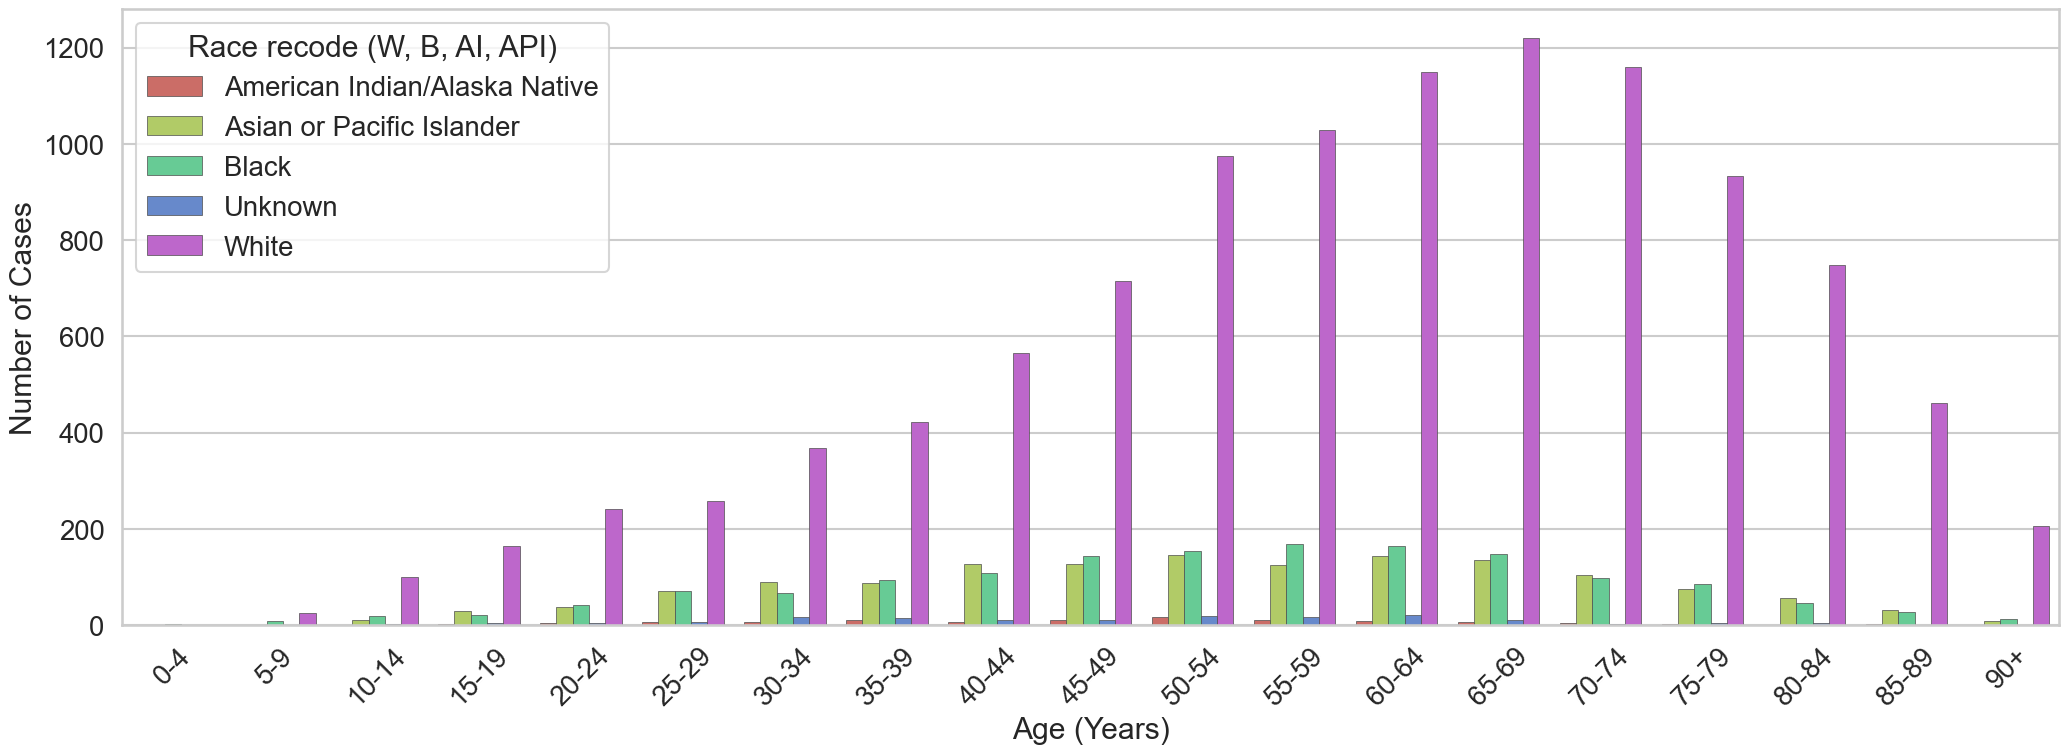

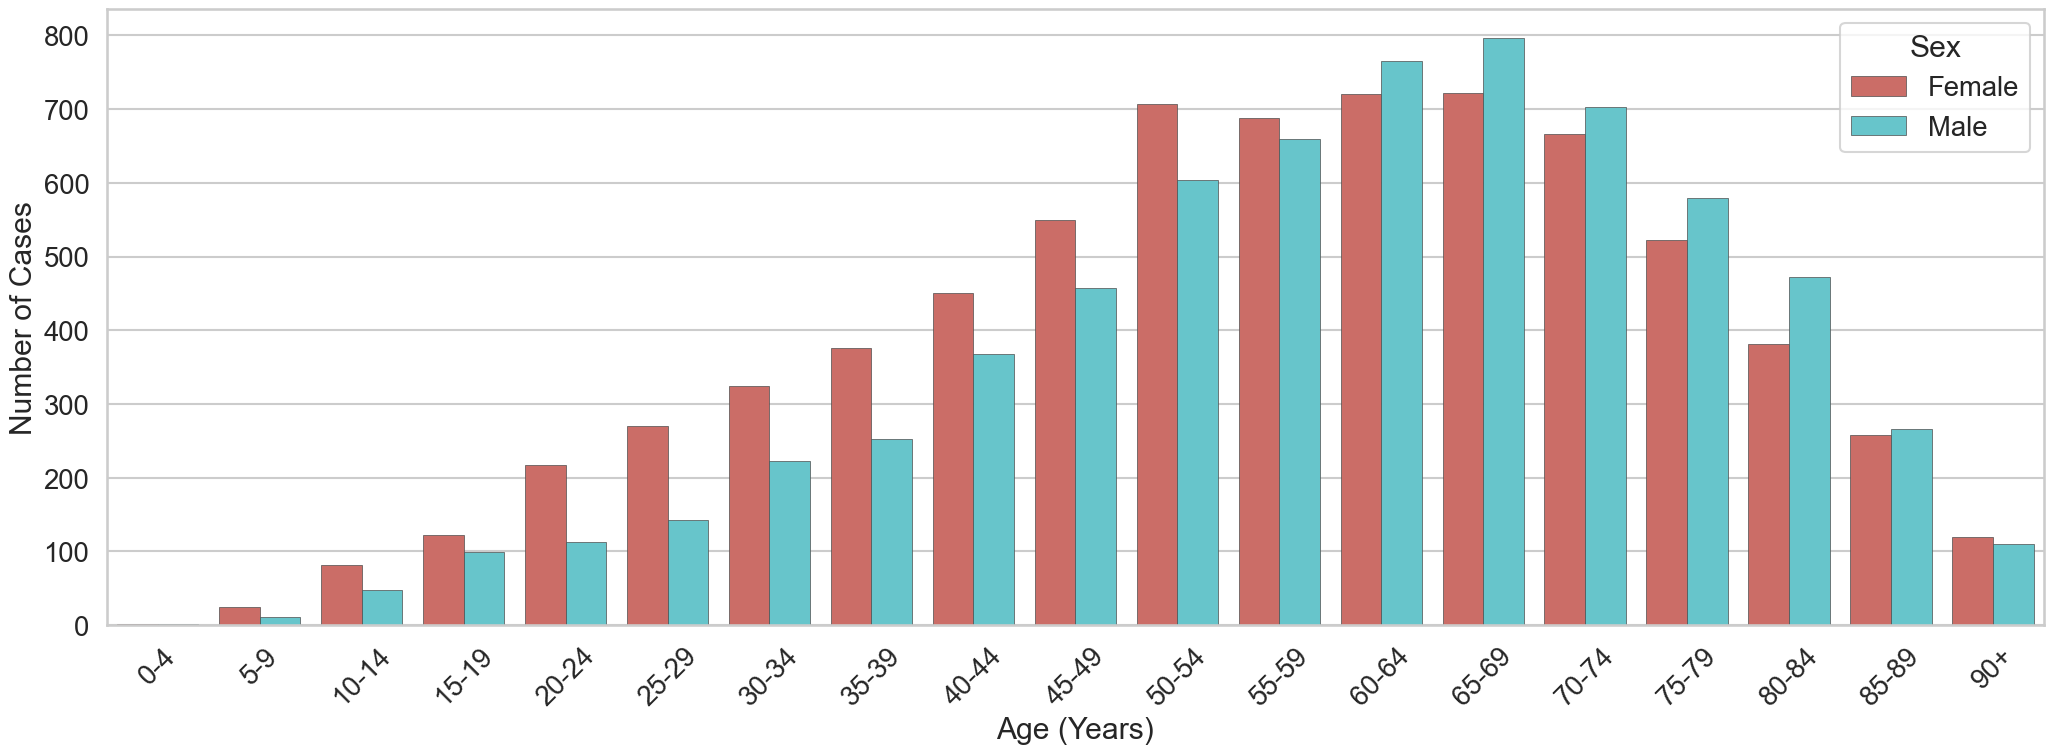

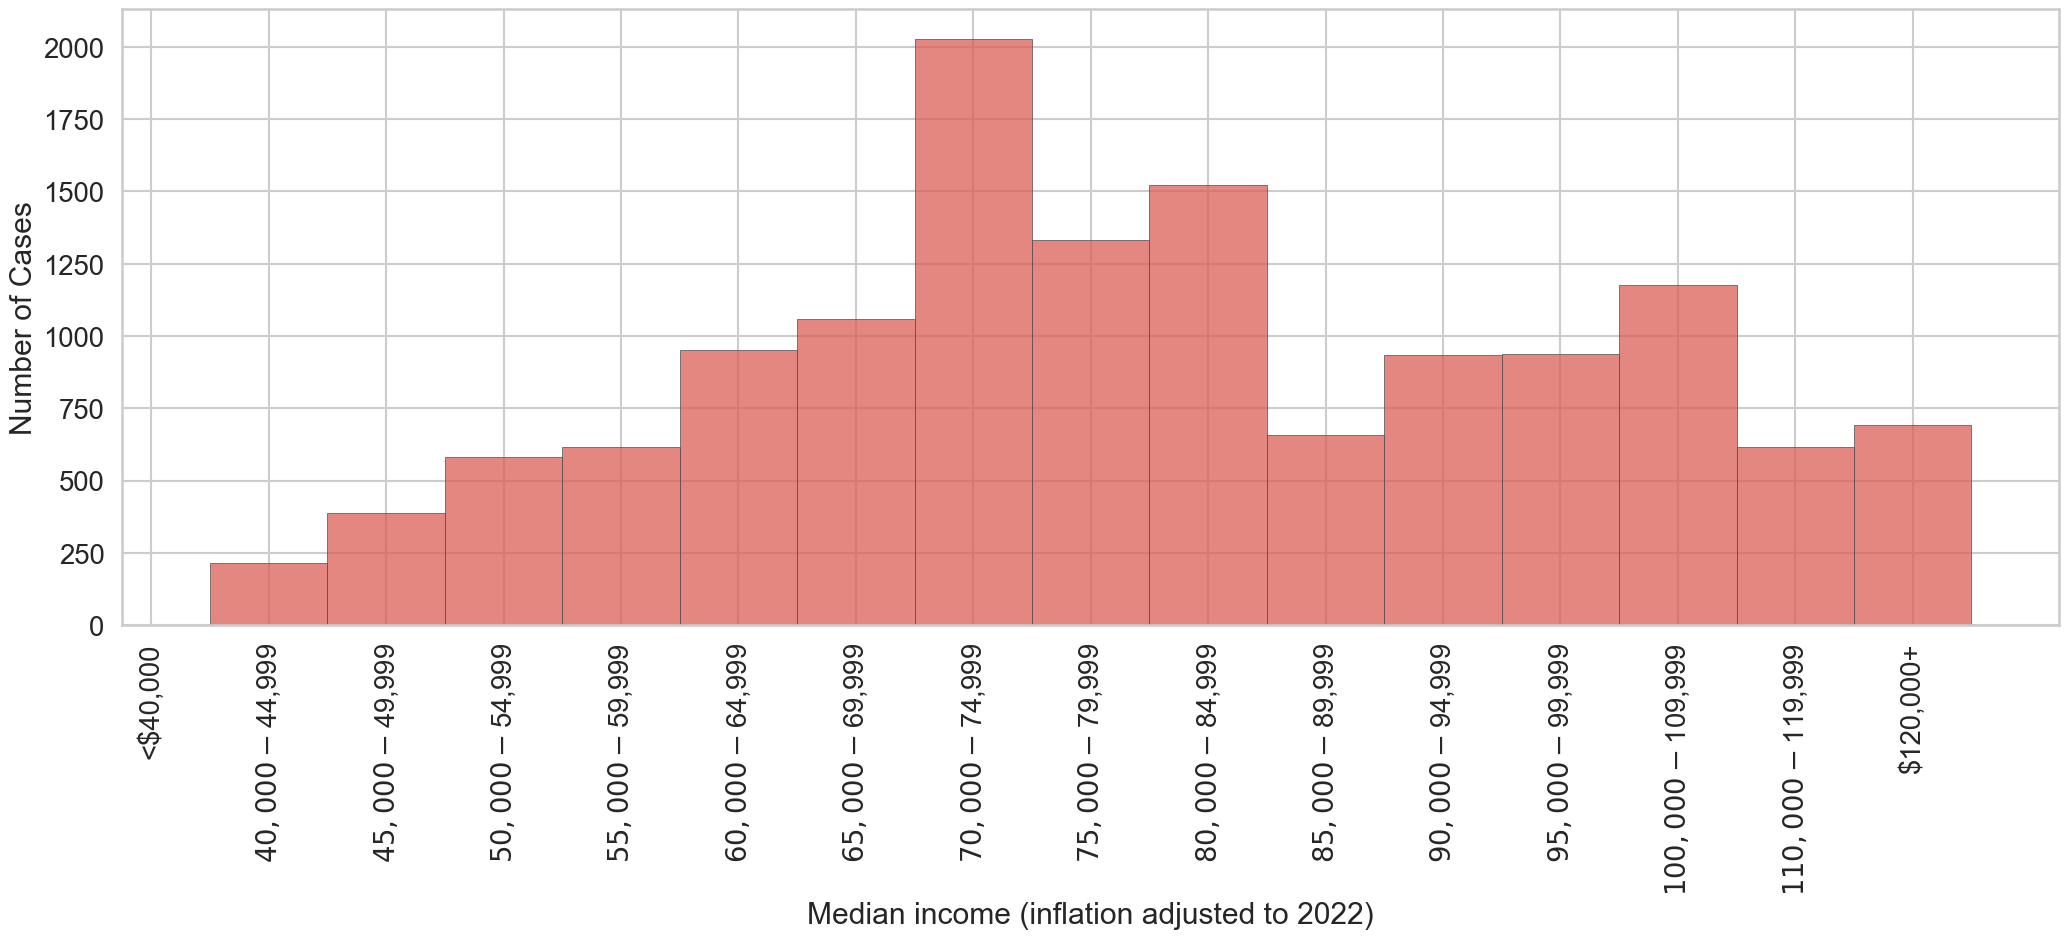

In [10]:
# Plot - countplot
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')

# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=race_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=sex_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=filtered_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')


# Age - Unbinned

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/1940405346.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/1940405346.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/1940405346.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/1940405346.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xtickla

Text(0, 0.5, 'Number of Cases')

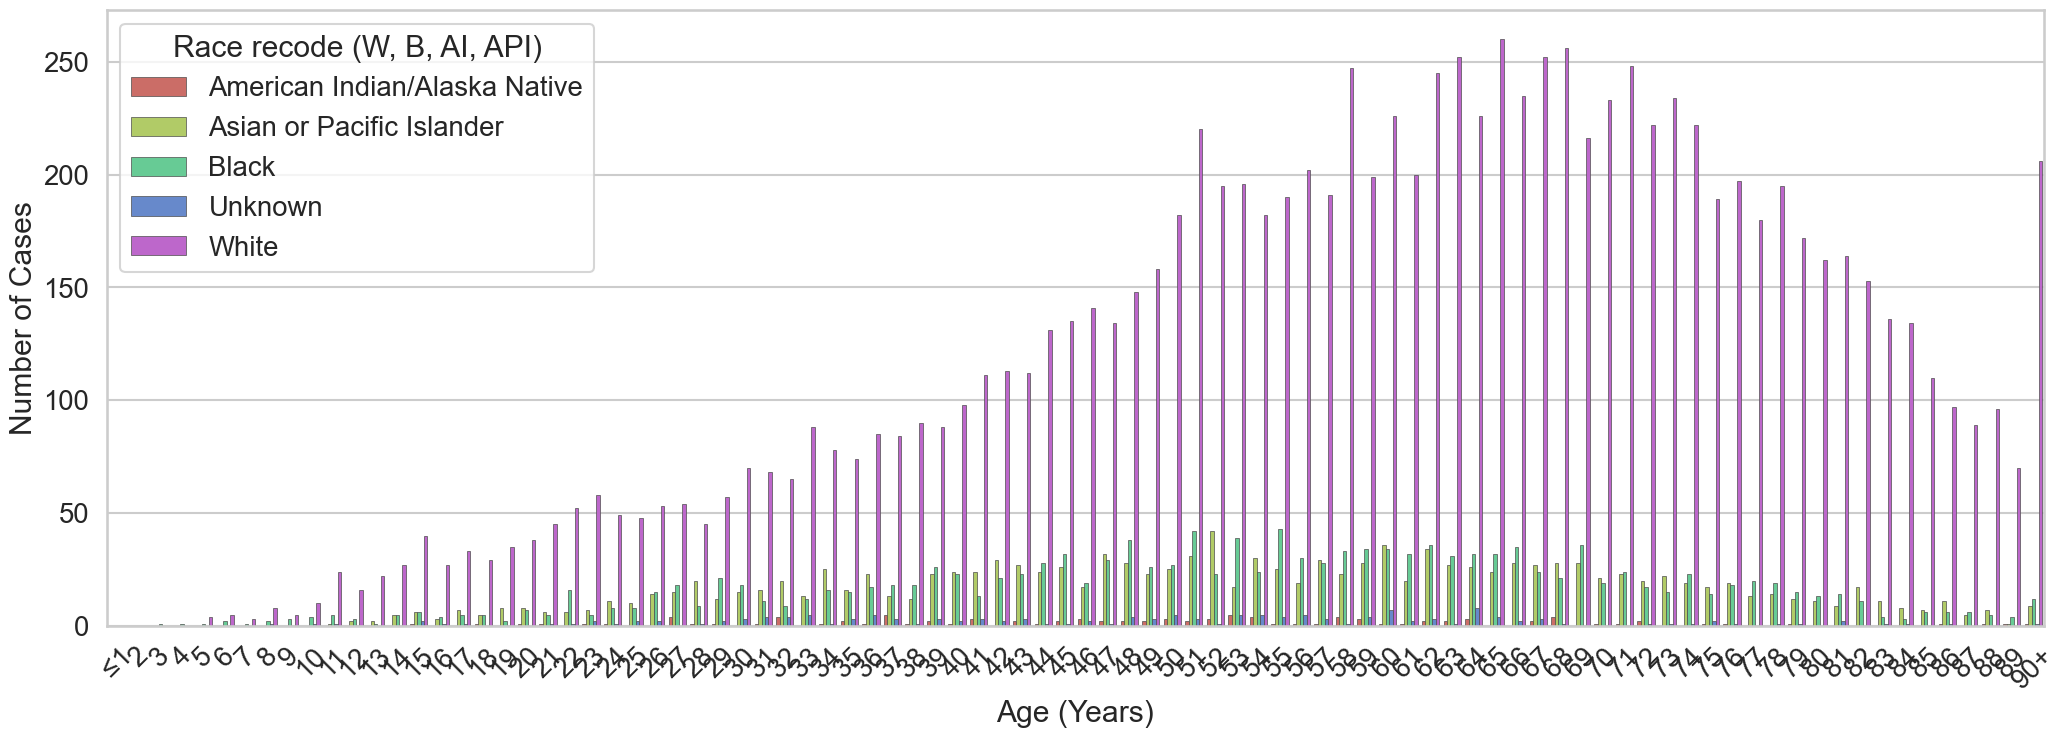

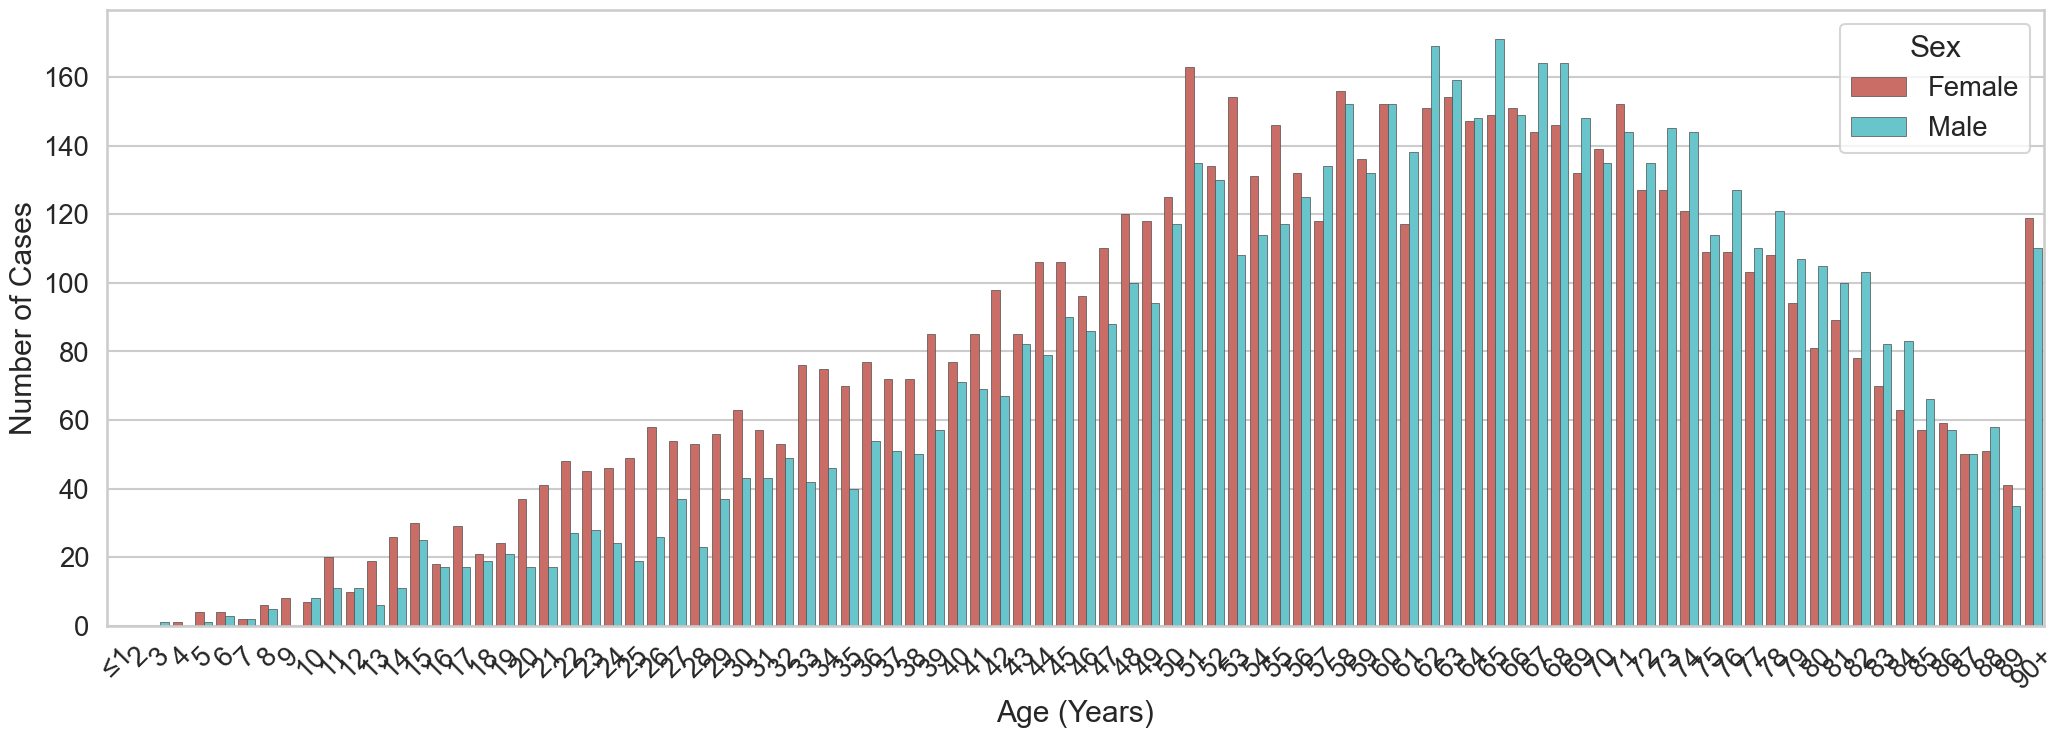

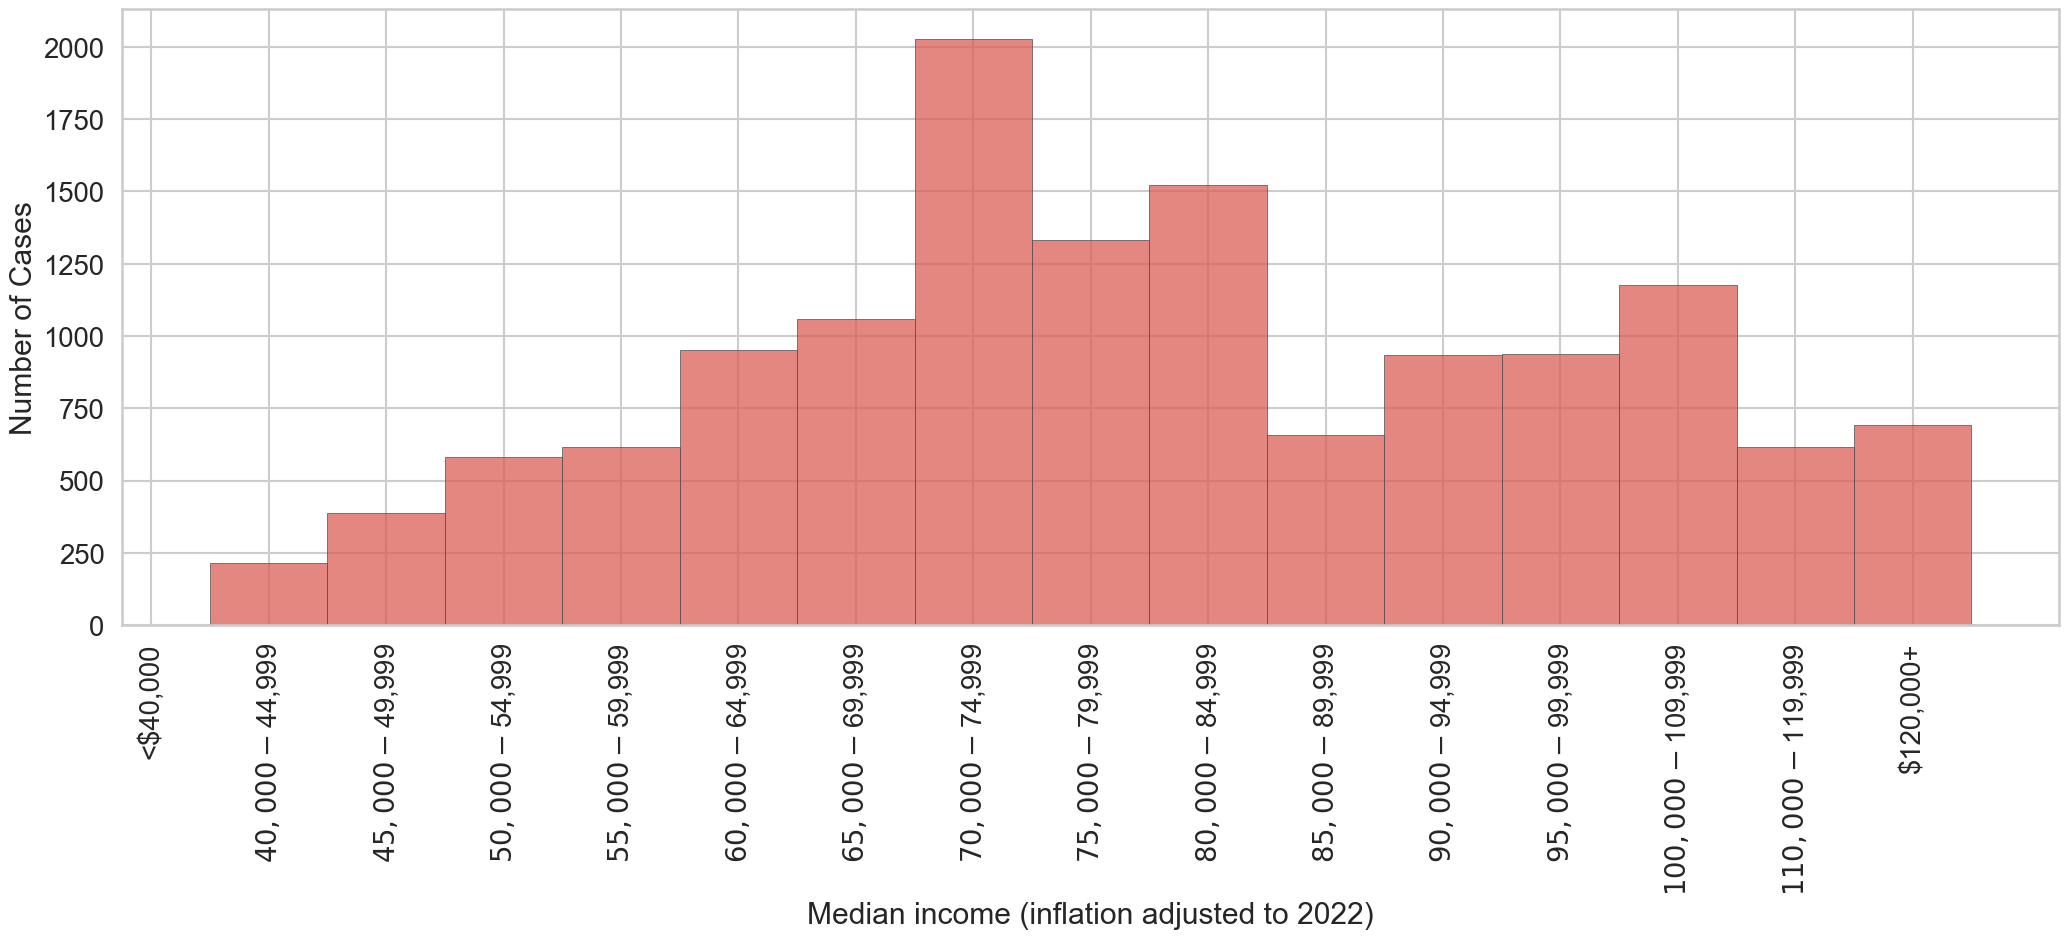

In [11]:
# Plot - countplot
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')

# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=filtered_df,
    x=age_colname,
    hue=race_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=filtered_df,
    x=age_colname,
    hue=sex_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=filtered_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/3071125564.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, '0-4'),
  Text(0, 1.5, '5-9'),
  Text(0, 2.5, '10-14'),
  Text(0, 3.5, '15-19'),
  Text(0, 4.5, '20-24'),
  Text(0, 5.5, '25-29'),
  Text(0, 6.5, '30-34'),
  Text(0, 7.5, '35-39'),
  Text(0, 8.5, '40-44'),
  Text(0, 9.5, '45-49'),
  Text(0, 10.5, '50-54'),
  Text(0, 11.5, '55-59'),
  Text(0, 12.5, '60-64'),
  Text(0, 13.5, '65-69'),
  Text(0, 14.5, '70-74'),
  Text(0, 15.5, '75-79'),
  Text(0, 16.5, '80-84'),
  Text(0, 17.5, '85-89'),
  Text(0, 18.5, '90+')])

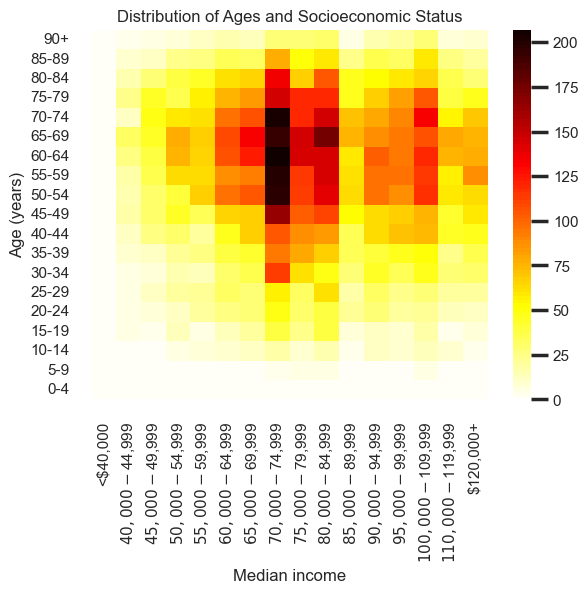

In [12]:
# Heatmap of age and socioeconomic
sns.set_context('poster',font_scale=.5)
# Create a pivot table that calculates the count of occurrences for each age and SES combination
# 
heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)

# Generate the RdYlGn palette with a specific number of colors
palette = sns.color_palette("hot_r",n_colors=100)
# Remove the darkest green, which is typically the last color in the RdYlGn palette
# You can adjust the indices depending on which colors you want to remove
# modified_palette = palette[:-1]  # This removes the last color

# Convert the modified list of colors to a colormap
cmap = sns.color_palette(palette, as_cmap=True)

# Create the heatmap
ses_heat = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt='d')
ses_heat.invert_yaxis()
plt.title('Distribution of Ages and Socioeconomic Status')
plt.xlabel('Median income')
plt.ylabel('Age (years)')
# plt.show()
# Rotate the y-axis labels
plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal (90º from the default)
# plt.close()

# Determine Histological Characterization + Order

In [13]:
# Histology order - Manually Defined and dependent on each dataset
histology_order = ['Adenoid Cystic Carcinoma','Adenocarcinoma','Mucoepidermoid Carcinoma','Other Rare Types','Mixed Subtypes']

# Categorize Histology column based on pre-ordained order
filtered_df['Histology'] = pd.Categorical(filtered_df['Histology'],categories=histology_order, ordered=True)

# For plotting FacetGrid determine the top N types
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order # top cancers

# Pick top N cancers for plotting
N = 3
topCancerTypes = ordered_labels[0:N]
print(topCancerTypes)
filtered_df_forFacetGrid = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]

filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()

# Color Set Up
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors

fullColorDict = dict(zip(histology_order,colors))
topNColorDict = dict(zip(topCancerTypes,colors[0:N]))

fullColorDict

['Adenoid Cystic Carcinoma', 'Adenocarcinoma', 'Mucoepidermoid Carcinoma']


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/1237648846.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()


{'Adenoid Cystic Carcinoma': '#FFB200',
 'Adenocarcinoma': '#30B7AE',
 'Mucoepidermoid Carcinoma': '#BFEF8E',
 'Other Rare Types': '#ffabab',
 'Mixed Subtypes': '#96f1ff'}

## Distribution by Age & Pie Plot

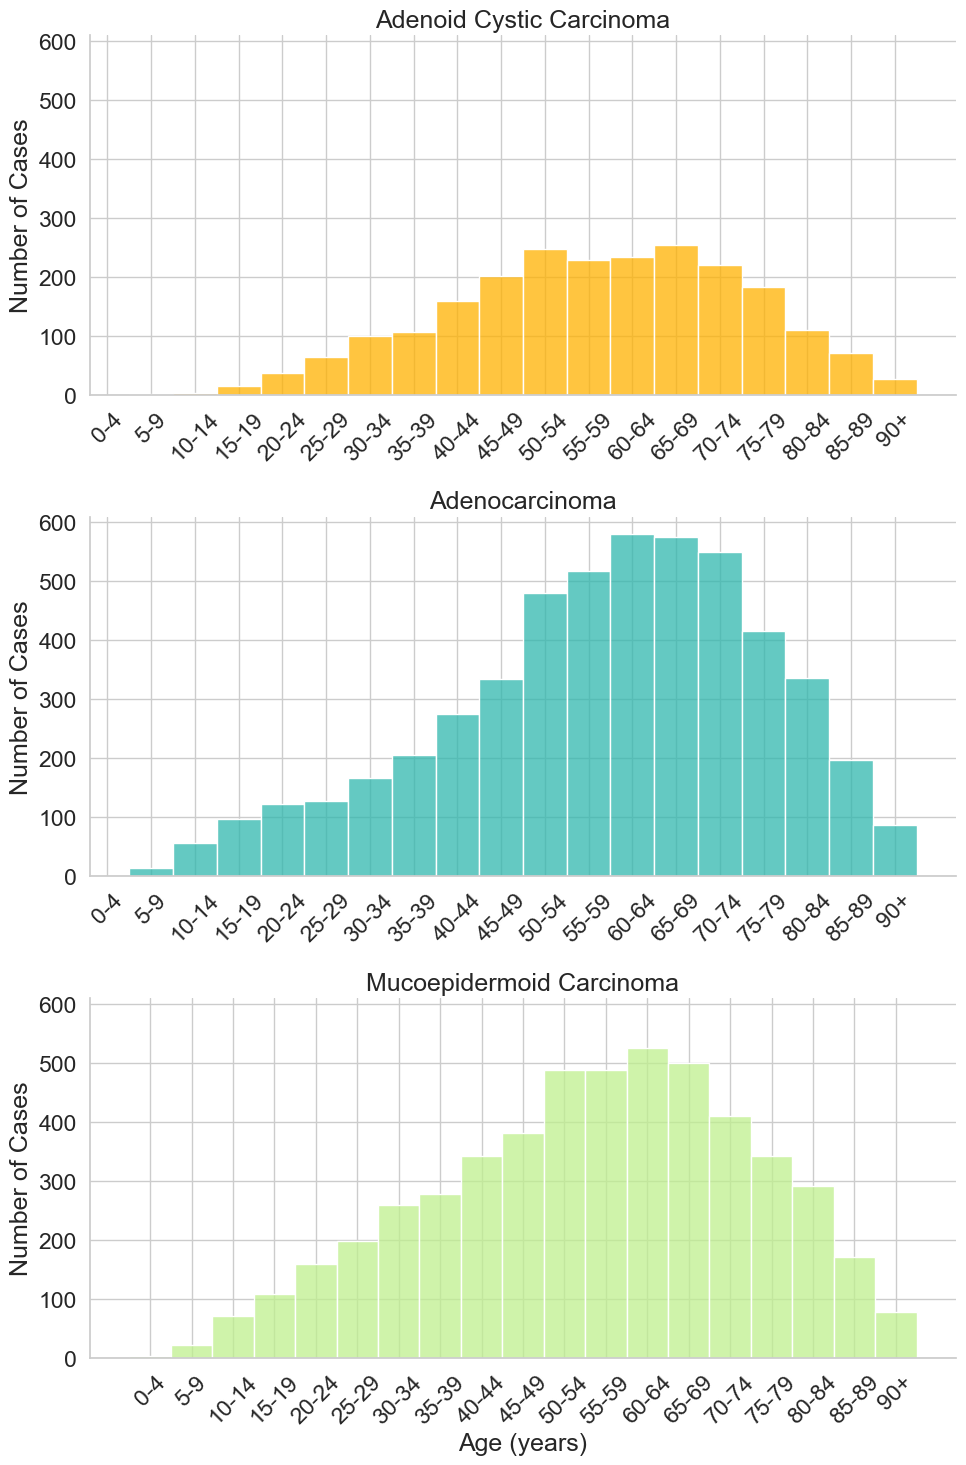

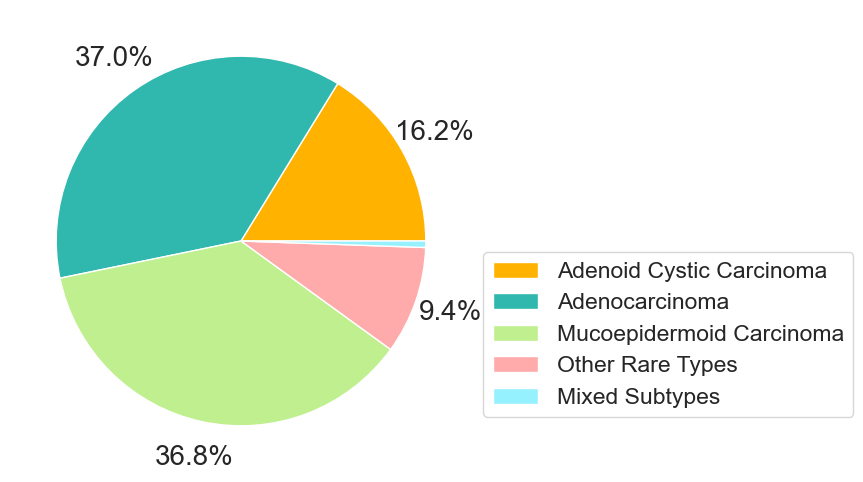

In [14]:
# Set the context for better visibility
sns.set_context("notebook", font_scale=1.5)

# Create a FacetGrid instead of using displot
g = sns.FacetGrid(filtered_df_forFacetGrid, col="Histology", col_wrap=1, height=5, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, x=age_bin_colname, binwidth=1, hue='Histology', palette=topNColorDict, multiple='stack')

# Rotate the x-tick labels in each facet
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set labels and titles
g.set_xlabels('Age (years)')
g.set_ylabels('Number of Cases')
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

# Calculate tumor site counts
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order

labels = tumor_type_counts.index

# Create pie chart
plt.figure(figsize=(8, 6))
# Explicit colors definition:
colors_for_pie = [fullColorDict[label] for label in ordered_labels if label in fullColorDict]
# Define a function as an input to autopct:
def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct >= 1 else ''

# Create the pie chart with specified font sizes
patches, texts, autotexts = plt.pie(
    ordered_counts, labels=None, autopct=autopct_format,
    pctdistance=1.2, colors=colors_for_pie
)

# Adjust the font size for the pie chart
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(20)

# Add legend
plt.legend(patches, ordered_labels, loc='best', bbox_to_anchor=(1, 0.5))

plt.show()


# Cancer Types and Year of Diagnosis

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/3371906136.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()


,Year of diagnosis,Total Counts
16,2000,579
21,2001,517
19,2002,539
20,2003,518
14,2004,594
18,2005,572
13,2006,628
17,2007,573
7,2008,657
15,2009,588


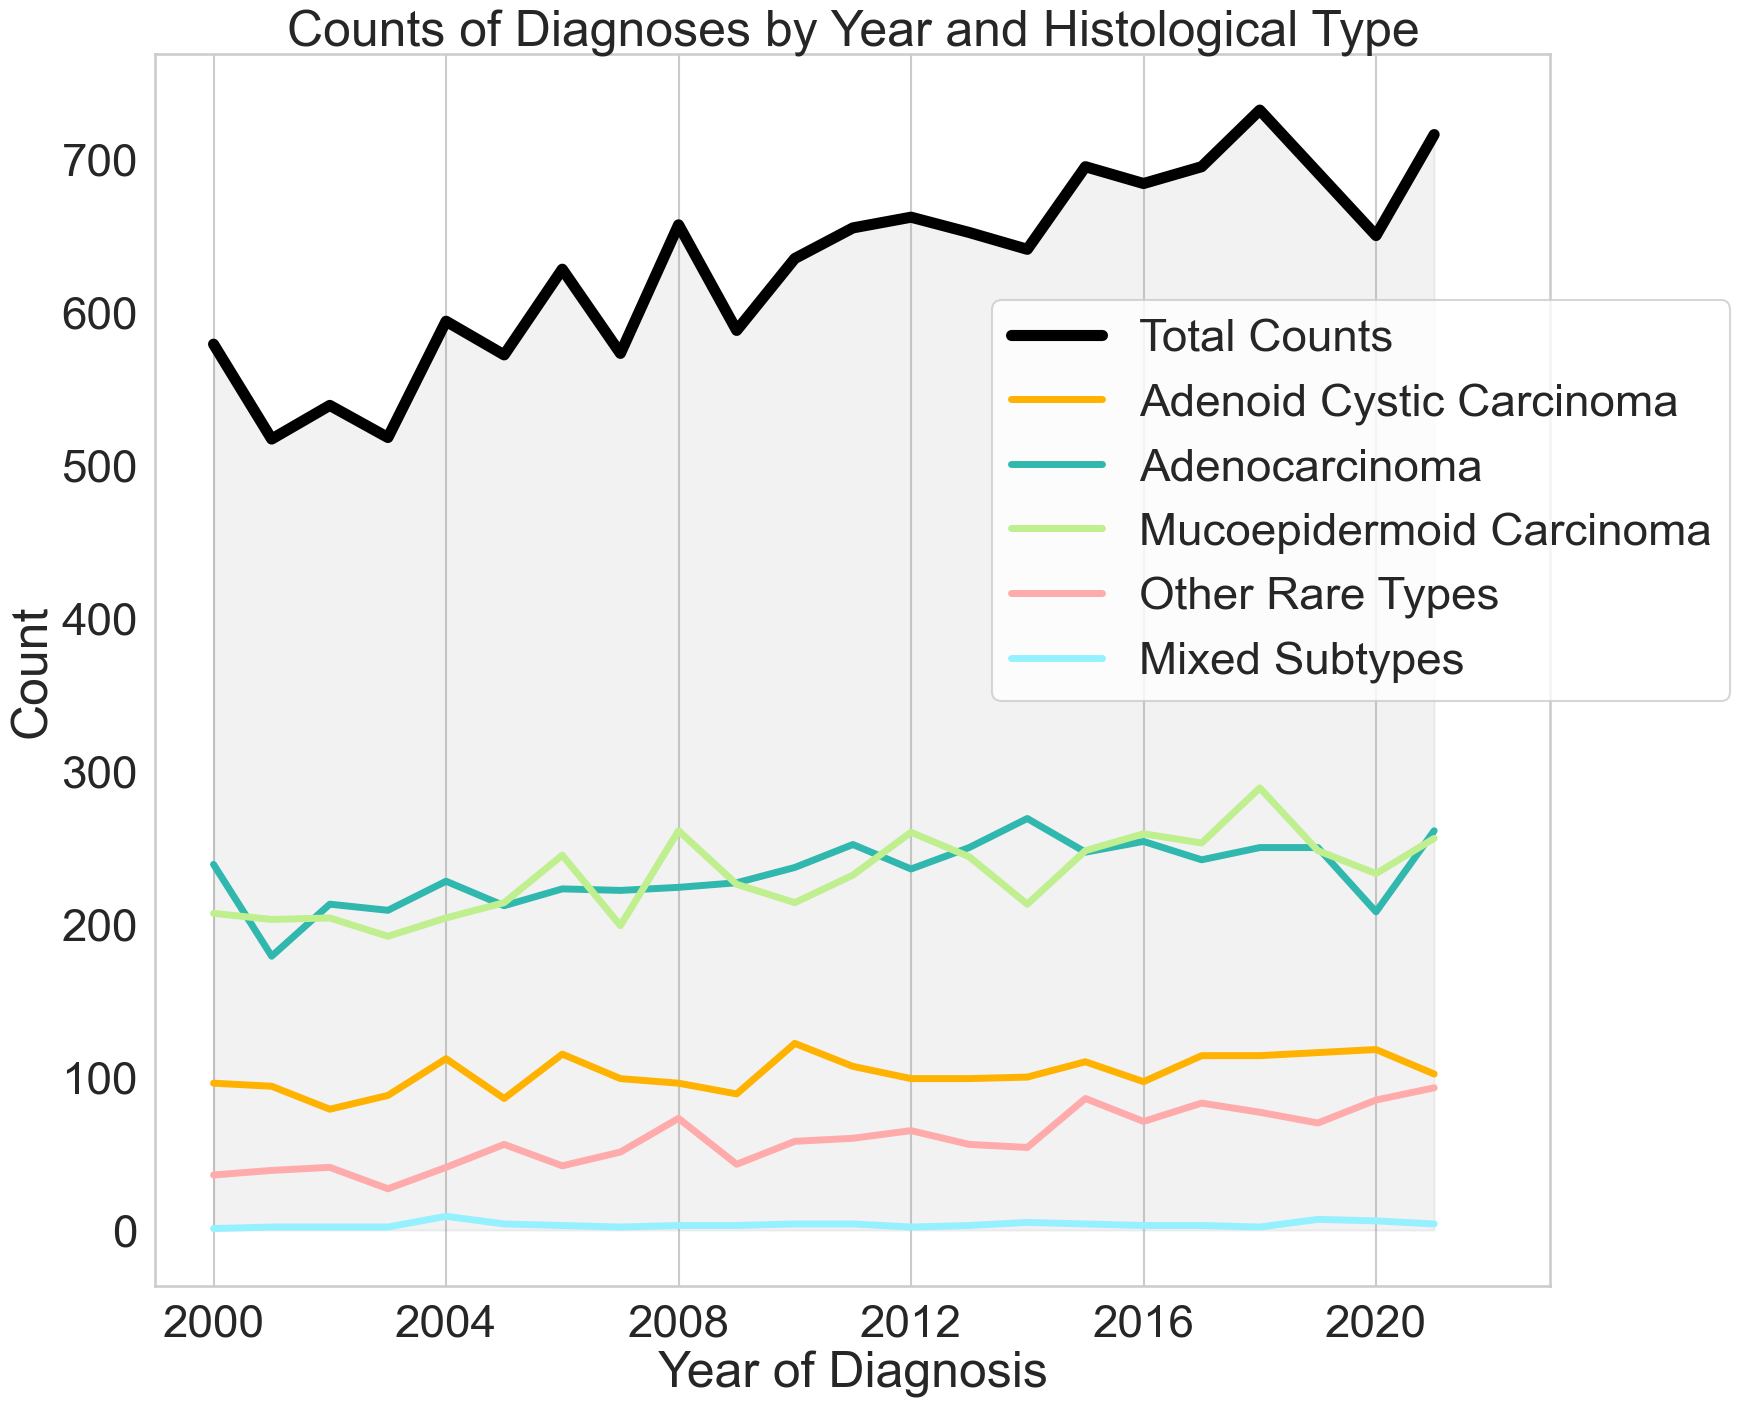

In [15]:
# Calculate counts per year per histological type.
type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()
type_year_counts_df = type_year_counts.reset_index(name='Counts')

# Calculate the counts per year for the bar plot
year_counts = filtered_df['Year of diagnosis'].value_counts()
year_counts_df = year_counts.reset_index(name='Total Counts')
year_counts_df.columns = ['Year of diagnosis', 'Total Counts']

# Ensure 'Year of diagnosis' is treated as an integer
year_counts_df['Year of diagnosis'] = year_counts_df['Year of diagnosis'].astype(int)
type_year_counts_df['Year of diagnosis'] = type_year_counts_df['Year of diagnosis'].astype(int)

# Sort both dataframes by 'Year of diagnosis' to ensure proper plotting order
year_counts_df = year_counts_df.sort_values('Year of diagnosis')
type_year_counts_df = type_year_counts_df.sort_values('Year of diagnosis')

# Display for verification
display(year_counts_df)

# Create plot and aesthetics
plt.figure(figsize=(18,16))
sns.set_context('talk', font_scale=2)

# Create the bar plot in the background for total counts per year
# sns.lineplot(year_counts_df,x='Year of diagnosis',y='Total Counts',
#              color=(0,0,0),lw=8,zorder=1,label='Total Count')
# Create the line plot for total counts per year
# We're using plt.plot instead of sns.lineplot to have more control over shading
plt.plot(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
         color='black', label='Total Counts', lw=8)

# Fill the area under the line with a shaded color
plt.fill_between(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
                 color='grey', alpha=0.1)

# Create line plot for each individual histological type
sns.lineplot(type_year_counts_df,x='Year of diagnosis',y='Counts',
             palette=colors,hue='Histology',lw=5,zorder=2)

# Adjust the x value limits
plt.xlim(1999,2023)
plt.xticks(range(2000,2022,4))
plt.grid(False, axis='y')
# Adjust legend position and add 'Total Counts' to the legend
plt.legend(bbox_to_anchor=(.6, .8), loc='upper left', borderaxespad=0.)

# Add labels and title
plt.xlabel('Year of Diagnosis')
plt.ylabel('Count')
plt.title('Counts of Diagnoses by Year and Histological Type')

plt.show()

# Survival Analysis
Data Preparation and Clinical Column Identification

In [18]:
# Select relevant columns for clinical characteristics analysis
clinical_columns = ['Primary Site - labeled', 'Histologic Type ICD-O-3',
                     'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
                     'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
                     'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
                     'ICD-O-3 Hist/behav, malignant','Histology','ICD-O-3 Code','SEER cause-specific death classification',
                    'SEER other cause of death classification', 'Survival months',
                    'Survival months flag', 'COD to site rec KM',
                    'COD to site recode ICD-O-3 2023 Revision',
                    'COD to site recode ICD-O-3 2023 Revision Expanded (1999+)',
                    'Vital status recode (study cutoff used)', 'Sequence number',
                    'First malignant primary indicator', 'Primary by international rules']

# Creating a summary for clinical characteristics
clinical_summary = filtered_df[clinical_columns]

# Display the summary
display(clinical_summary)

vital_percentages = clinical_summary["Vital status recode (study cutoff used)"].value_counts(normalize=True) * 100
alive_percentage = vital_percentages["Alive"]
dead_percentage = vital_percentages["Dead"]

print(vital_percentages)

,Primary Site - labeled,Histologic Type ICD-O-3,Grade Recode (thru 2017),Derived Summary Grade 2018 (2018+),Grade Clinical (2018+),Grade Pathological (2018+),Laterality,Diagnostic Confirmation,ICD-O-3 Hist/behav,"ICD-O-3 Hist/behav, malignant",...,SEER other cause of death classification,Survival months,Survival months flag,COD to site rec KM,COD to site recode ICD-O-3 2023 Revision,COD to site recode ICD-O-3 2023 Revision Expanded (1999+),Vital status recode (study cutoff used),Sequence number,First malignant primary indicator,Primary by international rules
0,C07.9-Parotid gland,8041,Poorly differentiated; Grade III,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,"8041/3: Small cell carcinoma, NOS","8041/3: Small cell carcinoma, NOS",...,Dead (attributable to causes other than this c...,14.0,Complete dates are available and there are mor...,Myeloma,Plasma Cell Neoplasms and Immunoproliferative ...,Plasma Cell Neoplasms,Dead,3rd of 3 or more primaries,No,Yes
3,C07.9-Parotid gland,8200,Unknown,9,9,9,Right - origin of primary,Positive histology,8200/3: Adenoid cystic carcinoma,8200/3: Adenoid cystic carcinoma,...,Alive or dead due to cancer,25.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,4th of 4 or more primaries,No,Yes
5,C07.9-Parotid gland,8041,Undifferentiated; anaplastic; Grade IV,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,"8041/3: Small cell carcinoma, NOS","8041/3: Small cell carcinoma, NOS",...,Dead (attributable to causes other than this c...,11.0,Complete dates are available and there are mor...,Cerebrovascular Diseases,Cerebrovascular diseases,Cerebrovascular diseases,Dead,3rd of 3 or more primaries,No,Yes
6,C07.9-Parotid gland,8430,Well differentiated; Grade I,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,210.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
7,C07.9-Parotid gland,8430,Unknown,A,A,A,Left - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,34.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28014,C07.9-Parotid gland,8550,Unknown,9,9,9,Right - origin of primary,Positive histology,8550/3: Acinar cell carcinoma,8550/3: Acinar cell carcinoma,...,Alive or dead due to cancer,9.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
28015,C07.9-Parotid gland,8550,Unknown,C,C,C,Left - origin of primary,Positive histology,8550/3: Acinar cell carcinoma,8550/3: Acinar cell carcinoma,...,Alive or dead due to cancer,11.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
28020,C07.9-Parotid gland,8430,Unknown,9,9,9,Right - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,10.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
28024,C08.0-Submandibular gland,8430,Unknown,B,B,B,Right - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,3.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes


Vital status recode (study cutoff used)
Alive    64.362431
Dead     35.637569
Name: proportion, dtype: float64


## Kaplan Meier Survival Curves Figures

{'Adenoid Cystic Carcinoma': '#FFB200', 'Adenocarcinoma': '#30B7AE', 'Mucoepidermoid Carcinoma': '#BFEF8E'}


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/3514097512.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


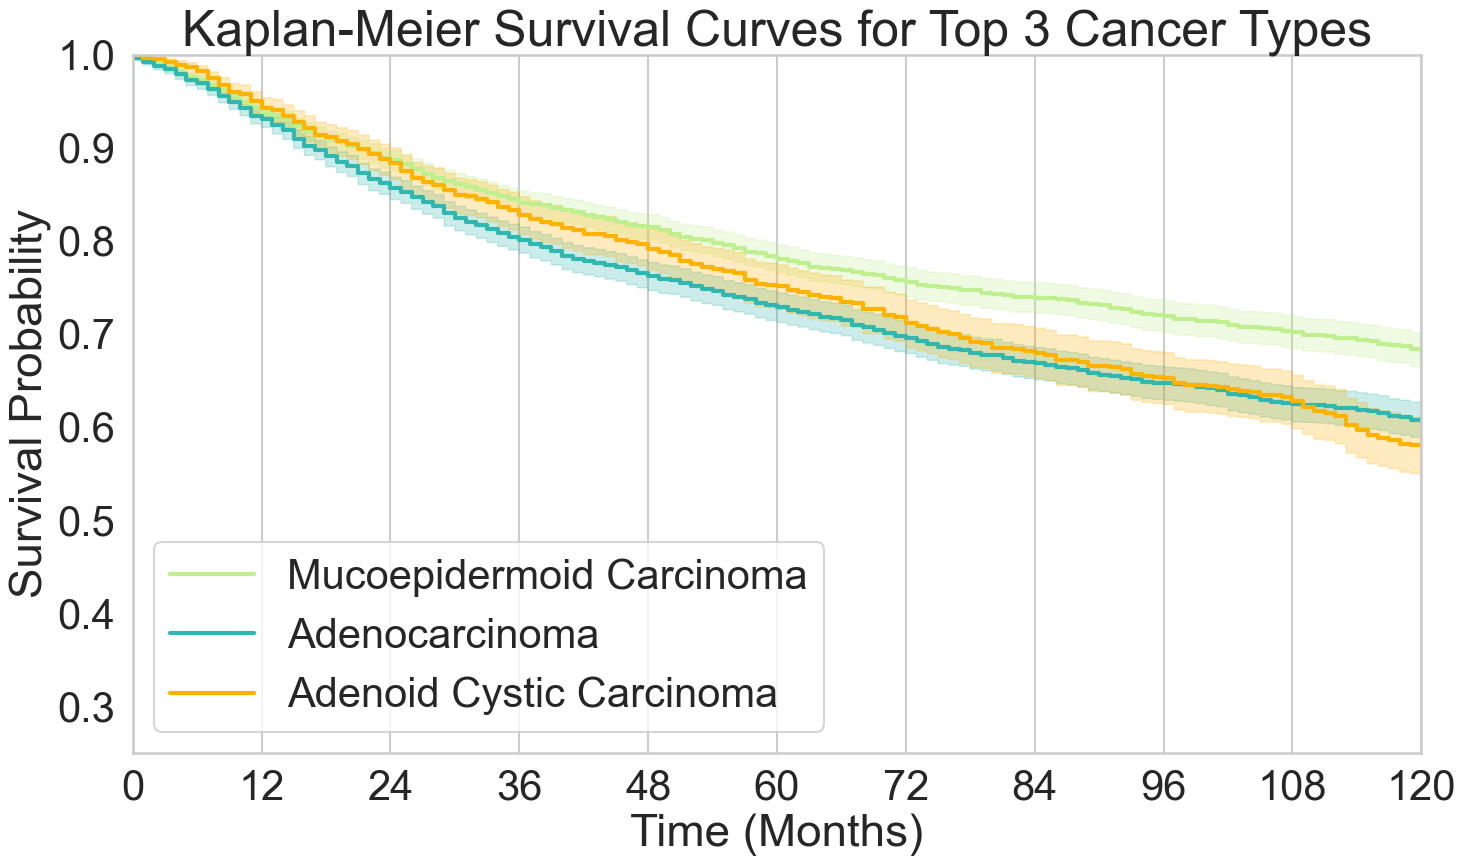

In [34]:
# Previously defined color mapping
print(topNColorDict)
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
# else 2 if x == 'Dead (missing/unknown COD)'
else 0)

# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique cancer types in your dataset
cancer_types = df['Histology'].unique()

# Create the plot
plt.figure(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for cancer_type in cancer_types:
    # Filter the DataFrame for each cancer type
    df_cancer = df[df['Histology'] == cancer_type]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_cancer['Survival months'], event_observed=df_cancer['event_occurred'], label=cancer_type)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=topNColorDict[cancer_type])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Top 3 Cancer Types', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Show the plot
plt.tight_layout()
plt.show()

In [39]:
(filtered_df[['Survival months', 'event_occurred', 'Age recode with single ages and 90+', 'Sex','Histology', 'Median household income inflation adj to 2022','RX Summ--Scope Reg LN Sur (2003+)', 'RX Summ--Surg Oth Reg/Dis (2003+)','RX Summ--Surg/Rad Seq', 'Chemotherapy recode (yes, no/unk)']])

,Primary Site - labeled,Histologic Type ICD-O-3,Grade Recode (thru 2017),Derived Summary Grade 2018 (2018+),Grade Clinical (2018+),Grade Pathological (2018+),Laterality,Diagnostic Confirmation,ICD-O-3 Hist/behav,"ICD-O-3 Hist/behav, malignant",...,SEER other cause of death classification,Survival months,Survival months flag,COD to site rec KM,COD to site recode ICD-O-3 2023 Revision,COD to site recode ICD-O-3 2023 Revision Expanded (1999+),Vital status recode (study cutoff used),Sequence number,First malignant primary indicator,Primary by international rules
0,C07.9-Parotid gland,8041,Poorly differentiated; Grade III,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,"8041/3: Small cell carcinoma, NOS","8041/3: Small cell carcinoma, NOS",...,Dead (attributable to causes other than this c...,14.0,Complete dates are available and there are mor...,Myeloma,Plasma Cell Neoplasms and Immunoproliferative ...,Plasma Cell Neoplasms,Dead,3rd of 3 or more primaries,No,Yes
3,C07.9-Parotid gland,8200,Unknown,9,9,9,Right - origin of primary,Positive histology,8200/3: Adenoid cystic carcinoma,8200/3: Adenoid cystic carcinoma,...,Alive or dead due to cancer,25.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,4th of 4 or more primaries,No,Yes
5,C07.9-Parotid gland,8041,Undifferentiated; anaplastic; Grade IV,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,"8041/3: Small cell carcinoma, NOS","8041/3: Small cell carcinoma, NOS",...,Dead (attributable to causes other than this c...,11.0,Complete dates are available and there are mor...,Cerebrovascular Diseases,Cerebrovascular diseases,Cerebrovascular diseases,Dead,3rd of 3 or more primaries,No,Yes
6,C07.9-Parotid gland,8430,Well differentiated; Grade I,Blank(s),Blank(s),Blank(s),Right - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,210.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
7,C07.9-Parotid gland,8430,Unknown,A,A,A,Left - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,34.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28014,C07.9-Parotid gland,8550,Unknown,9,9,9,Right - origin of primary,Positive histology,8550/3: Acinar cell carcinoma,8550/3: Acinar cell carcinoma,...,Alive or dead due to cancer,9.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
28015,C07.9-Parotid gland,8550,Unknown,C,C,C,Left - origin of primary,Positive histology,8550/3: Acinar cell carcinoma,8550/3: Acinar cell carcinoma,...,Alive or dead due to cancer,11.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,2nd of 2 or more primaries,No,Yes
28020,C07.9-Parotid gland,8430,Unknown,9,9,9,Right - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,10.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes
28024,C08.0-Submandibular gland,8430,Unknown,B,B,B,Right - origin of primary,Positive histology,8430/3: Mucoepidermoid carcinoma,8430/3: Mucoepidermoid carcinoma,...,Alive or dead due to cancer,3.0,Complete dates are available and there are mor...,Alive,Alive,Alive,Alive,One primary only,Yes,Yes


# Cox Hazard Ratio

## Data Preparation including one-hot encoding and addressing collinearities

In [85]:
# Filter the dataset to include only relevant columns for the Cox model
cox_df = filtered_df[['Survival months', 'event_occurred', 'Age recode with single ages and 90+', 'Sex','Histology', 'Median household income inflation adj to 2022'] + colsOfInterest_Tx]

# Handle special cases in various columns
age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
cox_df['Age recode with single ages and 90+'] = cox_df['Age recode with single ages and 90+'].replace(age_replacement).astype(float)

# Option 2: Drop rows with 'Blank(s)' if you want to remove them
# cox_df = cox_df[~cox_df[colsOfInterest_Tx].isin(['Blank(s)'])]

# Drop rows where required fields are missing (e.g., Survival months or event_occurred)
cox_df = cox_df.dropna(subset=['Survival months', 'event_occurred'])

# # One-Hot Encoding for CoxPH
cox_df = pd.get_dummies(cox_df, columns=['Sex', 'Histology', 'Chemotherapy recode (yes, no/unk)','Median household income inflation adj to 2022'] + colsOfInterest_Tx, drop_first=True)

# Drop any remaining rows with missing values
cox_df = cox_df.dropna()

# Check the correlation between variables
correlation_matrix = cox_df.corr()

# Display high correlations (e.g., above 0.8)
high_corr = correlation_matrix[(correlation_matrix > 0.75) & (correlation_matrix < 1)].stack()
print(high_corr)

RX Summ--Surg/Rad Seq_No radiation and/or no surgery; unknown if surgery and/or radiation given  Radiation recode_None/Unknown                                                                      0.875976
Radiation recode_None/Unknown                                                                    RX Summ--Surg/Rad Seq_No radiation and/or no surgery; unknown if surgery and/or radiation given    0.875976
dtype: float64


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/740416128.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cox_df['Age recode with single ages and 90+'] = cox_df['Age recode with single ages and 90+'].replace(age_replacement).astype(float)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_72655/740416128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_df['Age recode with single ages and 90+'] = cox_df['Age recode with single ages and 90+'].replace(age_replacement).astype(float)


In [89]:
# Drop offending columns and columns with low variability

# Remove highly correlated columns manually or use drop_first in One-Hot Encoding
# You can start by dropping the most problematic ones
columns_to_drop = ['Radiation recode_None/Unknown','RX Summ--Surg/Rad Seq_Surgery both before and after radiation',
                   'RX Summ--Surg/Rad Seq_No radiation and/or no surgery; unknown if surgery and/or radiation given']

# Drop these columns if they exist in the data
cox_df = cox_df.drop(columns=columns_to_drop, errors='ignore')


### Actual Model Fitting

In [92]:

# Use L2 regularization to address remaining collinearity
cox_model = CoxPHFitter(penalizer=0.01)  # Adjust the penalizer value based on convergence

# Fit the model again
cox_model.fit(cox_df, duration_col='Survival months', event_col='event_occurred')

# Print the summary
cox_model.print_summary()

cox_summary = cox_model.summary

# Specify the Excel file path where the output will be saved
output_file_path = 'cox_model_summary.xlsx'

# Export the summary to an Excel file
cox_summary.to_excel(output_file_path)

print(f"Cox model summary exported successfully to {output_file_path}")



<lifelines.CoxPHFitter: fitted with 13865 total observations, 8929 right-censored observations>
             duration col = 'Survival months'
                event col = 'event_occurred'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 13865
number of events observed = 4936
   partial log-likelihood = -41362.79
         time fit was run = 2024-09-27 18:30:32 UTC

---
                                                                                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                       
Age recode with single ages and 90+                                                                             0.05      1.06      0.00            0.05            0.06                1.05                1.06
Sex_Male                                                                                                        0.33      1.39      0.03            0.28            0.39                1.32                1.48
Histology_Adenocarcinoma                                                                                       -0.07      0.93      0.04           -0.15            0.00                0.86                1.00
Histology_Mucoepidermoid Carcinoma                                                                             -0.15      0.86      0.04           -0.23           -0.07                0.79                0.93
Histology_Other Rare Types                                                                                     -0.30      0.74      0.06           -0.41           -0.19                0.67                0.83
Histology_Mixed Subtypes                                                                                        0.45      1.56      0.15            0.14            0.75                1.15                2.11
Chemotherapy recode (yes, no/unk)_Yes                                                                           0.21      1.23      0.26           -0.30            0.72                0.74                2.05
Chemotherapy recode (yes, no/unk)_Yes                                                                           0.21      1.23      0.26           -0.30            0.72                0.74                2.05
Median household income inflation adj to 2022_$40,000 - $44,999                                                 0.00      1.00      0.13           -0.25            0.26                0.78                1.30
Median household income inflation adj to 2022_$45,000 - $49,999                                                 0.08      1.08      0.11           -0.13            0.29                0.88                1.33
Median household income inflation adj to 2022_$50,000 - $54,999                                                 0.05      1.05      0.10           -0.14            0.24                0.87                1.27
Median household income inflation adj to 2022_$55,000 - $59,999                                                -0.02      0.98      0.10           -0.21            0.17                0.81                1.18
Median household income inflation adj to 2022_$60,000 - $64,999                                                -0.04      0.96      0.09           -0.22            0.14                0.81                1.15
Median household income inflation adj to 2022_$65,000 - $69,999                                                -0.07      0.93      0.09           -0.25            0.10                0.78                1.11
Median household income inflation adj to 2022_$70,000 - $74,999                                                -0.06      0.94      0.08           -0.22            0.09                0.80                1.

Cox model summary exported successfully to cox_model_summary.xlsx


Index(['Survival months', 'event_occurred',
       'Age recode with single ages and 90+', 'Sex_Male',
       'Histology_Adenocarcinoma', 'Histology_Mucoepidermoid Carcinoma',
       'Histology_Other Rare Types', 'Histology_Mixed Subtypes',
       'Chemotherapy recode (yes, no/unk)_Yes',
       'Median household income inflation adj to 2022_$40,000 - $44,999',
       'Median household income inflation adj to 2022_$45,000 - $49,999',
       'Median household income inflation adj to 2022_$50,000 - $54,999',
       'Median household income inflation adj to 2022_$55,000 - $59,999',
       'Median household income inflation adj to 2022_$60,000 - $64,999',
       'Median household income inflation adj to 2022_$65,000 - $69,999',
       'Median household income inflation adj to 2022_$70,000 - $74,999',
       'Median household income inflation adj to 2022_$75,000 - $79,999',
       'Median household income inflation adj to 2022_$80,000 - $84,999',
       'Median household income inflation adj 